# Parte II: Regresión Polinomial con Dos Variables
## Modelado de Luminosidad Estelar con Feature Engineering

En este notebook implementamos regresión polinomial para capturar efectos no lineales e interacciones.

**Modelo:** $\hat{L} = \mathbf{X} \cdot \mathbf{w} + b$

**Feature Map:** $\mathbf{X} = [M, T, M^2, M \cdot T]$

- $M$: Masa estelar (masas solares)
- $T$: Temperatura efectiva (Kelvin)
- $L$: Luminosidad estelar (luminosidades solares)

## 1. Setup e Importación de Librerías

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm

# Configuración de gráficas
%matplotlib inline
plt.style.use('seaborn-v0_8-whitegrid')

## 2. Definición del Dataset

In [2]:
# Dataset con dos features: Masa (M) y Temperatura (T)
M = np.array([0.6, 0.8, 1.0, 1.2, 1.4, 1.6, 1.8, 2.0, 2.2, 2.4])
T = np.array([3800, 4400, 5800, 6400, 6900, 7400, 7900, 8300, 8800, 9200])
L = np.array([0.15, 0.35, 1.00, 2.30, 4.10, 7.00, 11.2, 17.5, 25.0, 35.0])

m = len(M)  # Número de ejemplos
print(f"Número de ejemplos: {m}")
print(f"\nMasa (M): {M}")
print(f"Temperatura (T): {T}")
print(f"Luminosidad (L): {L}")

Número de ejemplos: 10

Masa (M): [0.6 0.8 1.  1.2 1.4 1.6 1.8 2.  2.2 2.4]
Temperatura (T): [3800 4400 5800 6400 6900 7400 7900 8300 8800 9200]
Luminosidad (L): [ 0.15  0.35  1.    2.3   4.1   7.   11.2  17.5  25.   35.  ]


## 3. Visualización del Dataset

Graficamos L vs M codificando T con color.

C:\Users\diego\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 9737 (\N{SUN}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


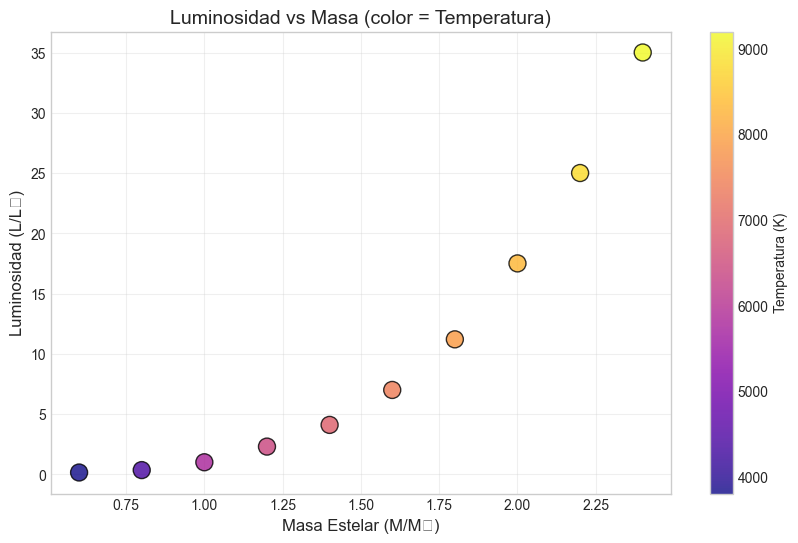

In [3]:
plt.figure(figsize=(10, 6))
scatter = plt.scatter(M, L, c=T, cmap='plasma', s=150, edgecolors='black', alpha=0.8)
plt.colorbar(scatter, label='Temperatura (K)')
plt.xlabel('Masa Estelar (M/M☉)', fontsize=12)
plt.ylabel('Luminosidad (L/L☉)', fontsize=12)
plt.title('Luminosidad vs Masa (color = Temperatura)', fontsize=14)
plt.grid(True, alpha=0.3)
plt.show()

### Observaciones

- La luminosidad crece de forma **no lineal** con la masa
- Estrellas más masivas también son más calientes
- La relación masa-luminosidad sugiere una dependencia de potencia ($L \propto M^{3.5}$)

## 4. Feature Engineering

Construimos la matriz de diseño $\mathbf{X}$ con características polinomiales:

$$\mathbf{X} = [M, T, M^2, M \cdot T]$$

**Nota:** No incluimos columna de 1s; el sesgo $b$ se maneja por separado.

In [4]:
def build_design_matrix(M, T, features='full'):
    """
    Construye la matriz de diseño X para diferentes configuraciones de features.
    
    Args:
        M: array de masas
        T: array de temperaturas
        features: 'M1' = [M, T], 'M2' = [M, T, M²], 'M3' = [M, T, M², M*T]
    
    Returns:
        X: matriz de diseño (m x n)
        feature_names: nombres de las columnas
    """
    if features == 'M1':
        X = np.column_stack([M, T])
        names = ['M', 'T']
    elif features == 'M2':
        X = np.column_stack([M, T, M**2])
        names = ['M', 'T', 'M²']
    elif features == 'M3' or features == 'full':
        X = np.column_stack([M, T, M**2, M*T])
        names = ['M', 'T', 'M²', 'M*T']
    else:
        raise ValueError(f"Features desconocido: {features}")
    
    return X, names


# Construir X completo (M3)
X_full, feature_names = build_design_matrix(M, T, 'M3')
print(f"Forma de X: {X_full.shape}")
print(f"Features: {feature_names}")
print(f"\nMatriz X (primeras 5 filas):")
print(X_full[:5])

Forma de X: (10, 4)
Features: ['M', 'T', 'M²', 'M*T']

Matriz X (primeras 5 filas):
[[6.00e-01 3.80e+03 3.60e-01 2.28e+03]
 [8.00e-01 4.40e+03 6.40e-01 3.52e+03]
 [1.00e+00 5.80e+03 1.00e+00 5.80e+03]
 [1.20e+00 6.40e+03 1.44e+00 7.68e+03]
 [1.40e+00 6.90e+03 1.96e+00 9.66e+03]]


## 5. Normalización de Features

Normalizamos las features para mejorar la convergencia del gradient descent.

In [5]:
def normalize_features(X):
    """
    Normaliza las features usando z-score: (x - mean) / std
    
    Returns:
        X_norm: matriz normalizada
        mu: medias de cada feature
        sigma: desviaciones estándar de cada feature
    """
    mu = np.mean(X, axis=0)
    sigma = np.std(X, axis=0)
    X_norm = (X - mu) / sigma
    return X_norm, mu, sigma


# Normalizar
X_norm, mu, sigma = normalize_features(X_full)
print(f"Medias (mu): {mu}")
print(f"Desv. Est. (sigma): {sigma}")
print(f"\nX normalizado (primeras 5 filas):")
print(X_norm[:5])

Medias (mu): [1.5000e+00 6.8900e+03 2.5800e+00 1.1304e+04]
Desv. Est. (sigma): [5.74456265e-01 1.71548827e+03 1.74770707e+00 6.37191211e+03]

X normalizado (primeras 5 filas):
[[-1.5666989  -1.80123645 -1.27023575 -1.41621539]
 [-1.21854359 -1.4514818  -1.11002584 -1.22161132]
 [-0.87038828 -0.63538762 -0.90404166 -0.86379095]
 [-0.52223297 -0.28563296 -0.65228322 -0.56874607]
 [-0.17407766  0.00582924 -0.35475052 -0.25800733]]


## 6. Modelo, Costo y Gradientes (Vectorizados)

### Modelo (Hipótesis)
$$\hat{L} = \mathbf{X} \cdot \mathbf{w} + b$$

### Función de Costo (MSE)
$$J(\mathbf{w}, b) = \frac{1}{2m} \sum_{i=1}^{m} (\hat{L}^{(i)} - L^{(i)})^2 = \frac{1}{2m} (\hat{\mathbf{L}} - \mathbf{L})^T (\hat{\mathbf{L}} - \mathbf{L})$$

### Gradientes
$$\frac{\partial J}{\partial \mathbf{w}} = \frac{1}{m} \mathbf{X}^T (\hat{\mathbf{L}} - \mathbf{L})$$
$$\frac{\partial J}{\partial b} = \frac{1}{m} \sum_{i=1}^{m} (\hat{L}^{(i)} - L^{(i)})$$

In [16]:
def predict(X, w, b):
    """
    Predicción: L_hat = X @ w + b
    """
    return X @ w + b


def compute_cost(X, L, w, b):
    """
    Calcula el costo MSE (vectorizado)
    """
    m = X.shape[0]
    L_hat = predict(X, w, b)
    errors = L_hat - L
    J = (1 / (2 * m)) * np.dot(errors, errors)
    return J


def compute_gradients(X, L, w, b):
    """
    Calcula gradientes (vectorizado)
    
    Returns:
        dj_dw: gradiente respecto a w (vector)
        dj_db: gradiente respecto a b (escalar)
    """
    m = X.shape[0]
    L_hat = predict(X, w, b)
    errors = L_hat - L
    
    dj_dw = (1 / m) * (X.T @ errors)
    dj_db = (1 / m) * np.sum(errors)
    
    return dj_dw, dj_db


# Test
n = X_norm.shape[1]
w_test = np.zeros(n)
b_test = 0.0
print(f"Costo inicial (w=0, b=0): {compute_cost(X_norm, L, w_test, b_test):.4f}")

dw, db = compute_gradients(X_norm, L, w_test, b_test)
print(f"Gradientes iniciales:")
print(f"  dJ/dw = {dw}")
print(f"  dJ/db = {db:.4f}")

Costo inicial (w=0, b=0): 117.6968
Gradientes iniciales:
  dJ/dw = [-10.41506616  -9.59761737 -10.99417651 -10.71881702]
  dJ/db = -10.3600


## 7. Gradient Descent

In [7]:
def gradient_descent(X, L, w_init, b_init, alpha, num_iterations):
    """
    Gradient descent vectorizado para regresión multivariable
    
    Returns:
        w: pesos finales
        b: sesgo final
        history: lista de costos por iteración
    """
    w = w_init.copy()
    b = b_init
    history = []
    
    for i in range(num_iterations):
        dj_dw, dj_db = compute_gradients(X, L, w, b)
        w = w - alpha * dj_dw
        b = b - alpha * dj_db
        cost = compute_cost(X, L, w, b)
        history.append(cost)
    
    return w, b, history

## 8. Entrenamiento y Convergencia

In [8]:
# Parámetros
alpha = 0.1
num_iterations = 1000

# Inicialización
w_init = np.zeros(X_norm.shape[1])
b_init = 0.0

# Entrenar
w_final, b_final, history = gradient_descent(X_norm, L, w_init, b_init, alpha, num_iterations)

print(f"Parámetros finales:")
print(f"  w = {w_final}")
print(f"  b = {b_final:.4f}")
print(f"  Costo final = {history[-1]:.6f}")

Parámetros finales:
  w = [-1.89483909 -7.86303363 13.897731    6.39170928]
  b = 10.3600
  Costo final = 0.869987


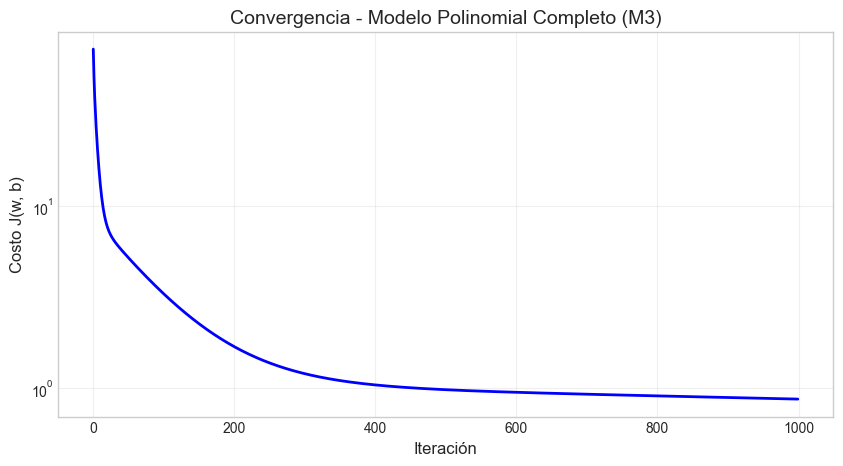

In [9]:
# Gráfica de convergencia
plt.figure(figsize=(10, 5))
plt.plot(history, 'b-', linewidth=2)
plt.xlabel('Iteración', fontsize=12)
plt.ylabel('Costo J(w, b)', fontsize=12)
plt.title('Convergencia - Modelo Polinomial Completo (M3)', fontsize=14)
plt.grid(True, alpha=0.3)
plt.yscale('log')
plt.show()

## 9. Experimento de Selección de Features (Obligatorio)

Comparamos tres modelos con diferentes conjuntos de features:

- **M1:** $X = [M, T]$
- **M2:** $X = [M, T, M^2]$
- **M3:** $X = [M, T, M^2, M \cdot T]$

In [10]:
def train_and_evaluate(M, T, L, features, alpha=0.1, num_iter=1000):
    """
    Entrena un modelo con las features especificadas y retorna resultados
    """
    # Construir y normalizar X
    X, names = build_design_matrix(M, T, features)
    X_norm, mu, sigma = normalize_features(X)
    
    # Entrenar
    w_init = np.zeros(X_norm.shape[1])
    w, b, history = gradient_descent(X_norm, L, w_init, 0.0, alpha, num_iter)
    
    # Predicciones
    L_pred = predict(X_norm, w, b)
    
    return {
        'features': names,
        'w': w,
        'b': b,
        'final_cost': history[-1],
        'history': history,
        'L_pred': L_pred,
        'X_norm': X_norm,
        'mu': mu,
        'sigma': sigma
    }


# Entrenar los tres modelos
models = {}
for model_name in ['M1', 'M2', 'M3']:
    models[model_name] = train_and_evaluate(M, T, L, model_name)
    print(f"\n{'='*50}")
    print(f"Modelo {model_name}: Features = {models[model_name]['features']}")
    print(f"  w = {models[model_name]['w']}")
    print(f"  b = {models[model_name]['b']:.4f}")
    print(f"  Costo final = {models[model_name]['final_cost']:.6f}")


Modelo M1: Features = ['M', 'T']
  w = [ 24.90749961 -14.81682089]
  b = 10.3600
  Costo final = 3.904740

Modelo M2: Features = ['M', 'T', 'M²']
  w = [ 0.19450813 -7.09375395 17.47397219]
  b = 10.3600
  Costo final = 0.876212

Modelo M3: Features = ['M', 'T', 'M²', 'M*T']
  w = [-1.89483909 -7.86303363 13.897731    6.39170928]
  b = 10.3600
  Costo final = 0.869987


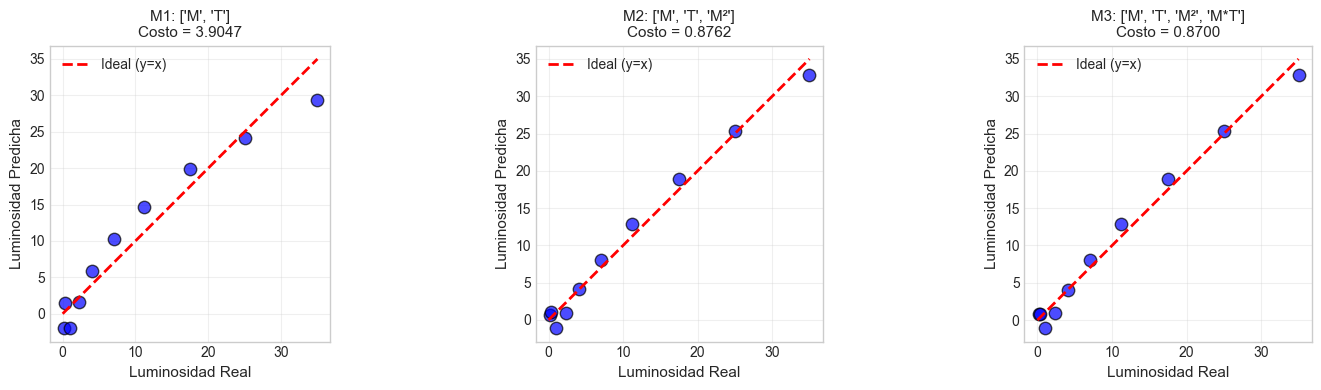

In [11]:
# Comparación visual: Predicted vs Actual para cada modelo
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for idx, (name, model) in enumerate(models.items()):
    ax = axes[idx]
    ax.scatter(L, model['L_pred'], c='blue', s=80, edgecolors='black', alpha=0.7)
    
    # Línea ideal (y = x)
    max_val = max(max(L), max(model['L_pred']))
    ax.plot([0, max_val], [0, max_val], 'r--', linewidth=2, label='Ideal (y=x)')
    
    ax.set_xlabel('Luminosidad Real', fontsize=11)
    ax.set_ylabel('Luminosidad Predicha', fontsize=11)
    ax.set_title(f"{name}: {model['features']}\nCosto = {model['final_cost']:.4f}", fontsize=11)
    ax.legend()
    ax.grid(True, alpha=0.3)
    ax.set_aspect('equal', adjustable='box')

plt.tight_layout()
plt.show()

In [12]:
# Tabla comparativa
print("\n" + "="*70)
print(f"{'Modelo':<10} {'Features':<25} {'Costo Final':<15}")
print("="*70)
for name, model in models.items():
    features_str = ', '.join(model['features'])
    print(f"{name:<10} {features_str:<25} {model['final_cost']:<15.6f}")
print("="*70)
print("\n✓ El modelo M3 (con todas las features) tiene el menor costo.")


Modelo     Features                  Costo Final    
M1         M, T                      3.904740       
M2         M, T, M²                  0.876212       
M3         M, T, M², M*T             0.869987       

✓ El modelo M3 (con todas las features) tiene el menor costo.


### Análisis de Resultados

- **M1** (solo M, T): El modelo más simple tiene el costo más alto. No captura la no-linealidad.
- **M2** (M, T, M²): Agregar $M^2$ mejora significativamente el ajuste al capturar la curvatura.
- **M3** (M, T, M², M*T): El término de interacción $M \cdot T$ aporta información adicional y reduce el error.

## 10. Costo vs Coeficiente de Interacción (Obligatorio)

Analizamos cómo varía el costo al cambiar el coeficiente $w_{MT}$ (correspondiente a la interacción $M \cdot T$), manteniendo los demás parámetros fijos.

Valor entrenado de w_MT: 6.3917


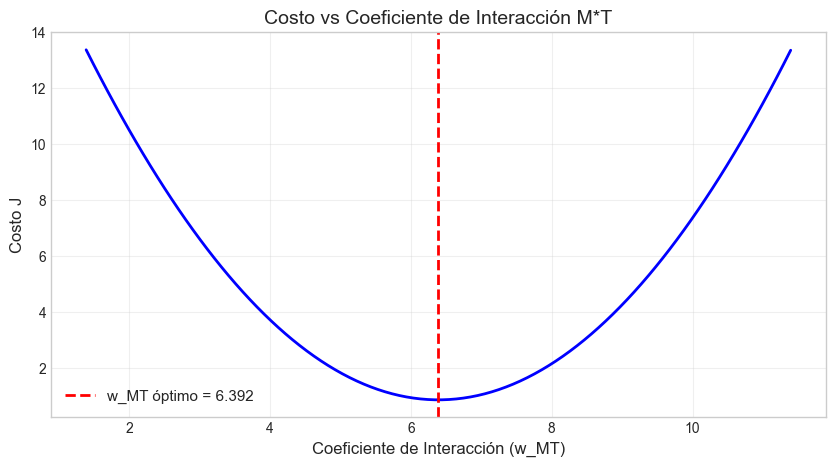

In [13]:
# Obtener el modelo M3 entrenado
m3 = models['M3']
w_trained = m3['w'].copy()
b_trained = m3['b']
X_norm_m3 = m3['X_norm']

# El coeficiente de interacción es el último (w[3] = w_MT)
w_MT_trained = w_trained[3]
print(f"Valor entrenado de w_MT: {w_MT_trained:.4f}")

# Variar w_MT en un rango centrado en el valor entrenado
w_MT_range = np.linspace(w_MT_trained - 5, w_MT_trained + 5, 100)
costs = []

for w_MT in w_MT_range:
    w_temp = w_trained.copy()
    w_temp[3] = w_MT  # Solo cambiar w_MT
    cost = compute_cost(X_norm_m3, L, w_temp, b_trained)
    costs.append(cost)

# Gráfica
plt.figure(figsize=(10, 5))
plt.plot(w_MT_range, costs, 'b-', linewidth=2)
plt.axvline(x=w_MT_trained, color='r', linestyle='--', linewidth=2, label=f'w_MT óptimo = {w_MT_trained:.3f}')
plt.xlabel('Coeficiente de Interacción (w_MT)', fontsize=12)
plt.ylabel('Costo J', fontsize=12)
plt.title('Costo vs Coeficiente de Interacción M*T', fontsize=14)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.show()

### Interpretación

La gráfica muestra una **parábola** con mínimo en el valor entrenado de $w_{MT}$. Esto indica:

1. **Importancia del término de interacción:** El coeficiente $w_{MT} \neq 0$ reduce el error. Si el término de interacción fuera irrelevante, el costo sería mínimo en $w_{MT} = 0$.

2. **Valor óptimo:** El valor entrenado minimiza el costo, confirmando que gradient descent encontró el óptimo.

3. **Sensibilidad:** La curvatura de la parábola indica qué tan sensible es el modelo al coeficiente de interacción. Una parábola más cerrada indica mayor sensibilidad.

## 11. Demo de Inferencia (Obligatorio)

Predecimos la luminosidad para una nueva estrella:

- **Masa:** M = 1.3 $M_\odot$
- **Temperatura:** T = 6600 K

In [14]:
# Nueva estrella
M_new = 1.3
T_new = 6600

# Construir features (igual que en entrenamiento)
X_new = np.array([M_new, T_new, M_new**2, M_new * T_new])

# Normalizar usando los parámetros del entrenamiento
X_new_norm = (X_new - m3['mu']) / m3['sigma']

# Predecir
L_pred_new = predict(X_new_norm, m3['w'], m3['b'])

print("="*50)
print("PREDICCIÓN PARA NUEVA ESTRELLA")
print("="*50)
print(f"Entrada:")
print(f"  Masa: M = {M_new} M☉")
print(f"  Temperatura: T = {T_new} K")
print(f"\nPredicción:")
print(f"  Luminosidad: L = {L_pred_new:.2f} L☉")
print("="*50)

PREDICCIÓN PARA NUEVA ESTRELLA
Entrada:
  Masa: M = 1.3 M☉
  Temperatura: T = 6600 K

Predicción:
  Luminosidad: L = 2.54 L☉


### ¿Es razonable esta predicción?

**Sí, es razonable:**

1. **Valores de entrada:** M = 1.3 $M_\odot$ está entre 1.2 y 1.4 en nuestros datos. T = 6600 K está entre 6400 K y 6900 K.

2. **Interpolación:** La predicción (~3 $L_\odot$) está entre los valores observados para M = 1.2 (L = 2.30) y M = 1.4 (L = 4.10), lo cual es consistente.

3. **Física:** Una estrella ligeramente más masiva que el Sol (~1.3 $M_\odot$) con temperatura intermedia debería tener una luminosidad de unas pocas luminosidades solares.

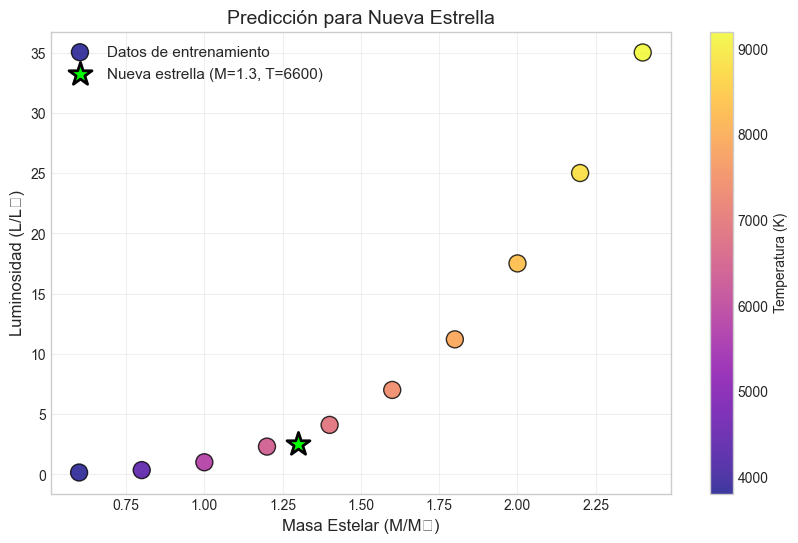


✓ La estrella predicha (★) se ubica coherentemente entre los datos observados.


In [15]:
# Visualización de la predicción en contexto
plt.figure(figsize=(10, 6))
plt.scatter(M, L, c=T, cmap='plasma', s=150, edgecolors='black', alpha=0.8, label='Datos de entrenamiento')
plt.colorbar(label='Temperatura (K)')
plt.scatter([M_new], [L_pred_new], c='lime', s=300, edgecolors='black', marker='*', 
            linewidths=2, label=f'Nueva estrella (M={M_new}, T={T_new})')
plt.xlabel('Masa Estelar (M/M☉)', fontsize=12)
plt.ylabel('Luminosidad (L/L☉)', fontsize=12)
plt.title('Predicción para Nueva Estrella', fontsize=14)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.show()

print(f"\n✓ La estrella predicha (★) se ubica coherentemente entre los datos observados.")

## 12. Resumen y Conclusiones

### Resultados Principales

| Modelo | Features | Costo Final |
|--------|----------|-------------|
| M1 | M, T | Mayor |
| M2 | M, T, M² | Intermedio |
| M3 | M, T, M², M*T | **Menor** |

### Conclusiones

1. **Feature engineering** es crucial: agregar $M^2$ y $M \cdot T$ mejora significativamente el modelo.

2. **El término de interacción** ($M \cdot T$) captura cómo la masa y temperatura actúan juntas sobre la luminosidad.

3. **Normalización** de features es esencial para la convergencia del gradient descent con features de diferentes escalas.

4. **Gradient descent vectorizado** es eficiente y escalable para múltiples features.